In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
from astropy.table import Table
import astropy
import os
from matplotlib.path import Path

In [2]:
def read_fits(name):
    hdulist = fits.open(name)
    field_data = hdulist[1].data
    header = hdulist[1].header
    hdulist.close()
    return field_data, header

# Step 1. We load the different files

In [3]:
field_list = ['12', '16']

In [18]:
data_dictionary = {}
coordinates_dictionary = {}
print('We have loaded the following files:')
for field in field_list:
    data_dictionary[field], header = read_fits('/home/pol/PhD_DATA/SMASH_DATA/Field%s_allobj_stars.fits.gz' % (field))
    coordinates_dictionary[field] = SkyCoord(data_dictionary[field]['RA'], data_dictionary[field]['DEC'], unit = 'deg')
    print field

We have loaded the following files:
12
16


# Step 2. We find the distances between all stars

In [14]:
for field in field_list:
    field_coordinates = coordinates_dictionary[field]
    for star in field_coordinates:
        all_distances = 

<SkyCoord (ICRS): (ra, dec) in deg
    [(15.90476785, -74.56239271), (15.92003673, -74.54928515),
     (16.05310659, -74.55173814), ..., (16.84750738, -74.94922557),
     (18.89483709, -74.94452378), (16.92823194, -75.38643206)]>
<SkyCoord (ICRS): (ra, dec) in deg
    [(20.79604346, -73.4388173 ), (20.79242883, -73.49742692),
     (20.79880173, -73.51437226), ..., (23.09667219, -74.86804309),
     (24.66426421, -75.02156516), (24.5574442 , -75.02267122)]>


In [ ]:
separation_dictionary = {}
for i, star in enumerate(coordinates_dictionary['12']):
    separation_dictionary[i] = star.separation(coordinates_dictionary['16'])

In [ ]:
plt.hist(separation_dictionary[0])
plt.show()

# Scrap everything, we are starting all over again

In [7]:
!python /user/HS128/pm00518/virtualenvs/venv/bin/nway-write-header.py /scratch/SMASH_DATA/Field16_allobj_stars.fits.gz 16 2.8 

current 12 SKYAREA: 2.81
new     16 SKYAREA: 2.8


In [8]:
!python /user/HS128/pm00518/virtualenvs/venv/bin/nway-write-header.py /scratch/SMASH_DATA/Field12_allobj_stars.fits.gz 12 2.81

current  SKYAREA: None
new     12 SKYAREA: 2.81


In [15]:
output_file = '/user/HS128/pm00518/SMASH_maps/output_test_12_16.fits'

In [18]:
!python nway.py /scratch/SMASH_DATA/Field16_allobj_stars.fits.gz :RAERR /scratch/SMASH_DATA/Field12_allobj_stars.fits.gz :RAERR --out=/scratch/SMASH_DATA/SMC_contiguous_catalogue/output_test_12_16.fits --radius 2

NWAY arguments:
    catalogues:  /scratch/SMASH_DATA/Field16_allobj_stars.fits.gz, /scratch/SMASH_DATA/Field12_allobj_stars.fits.gz
    position errors/columns:  :RAERR, :RAERR
      from catalogue "16" (392250), density gives 5.78e+09 on entire sky
      from catalogue "12" (515997), density gives 7.58e+09 on entire sky
    magnitude columns:  

matching with 2.000000 arcsec radius
matching: 202399823250 naive possibilities
matching: hashing
    using RA  columns: RA, RA
    using DEC columns: DEC, DEC
matching: healpix hashing on pixel resolution ~ 2.254538 arcsec (nside=65536)
100%|908247|####################################################|Time:  0:00:08
matching: collecting from 2136361 buckets, creating cartesian products ...
100%|2136361|###################################################|Time:  0:00:07
matching: 486159 unique matches from cartesian product. sorting ...
merging in 74 columns from input catalogues ...
100%| 74|#####################################################

In [21]:
!python nway.py /scratch/SMASH_DATA/Field16_allobj_stars.fits.gz :RAERR /scratch/SMASH_DATA/Field12_allobj_stars.fits.gz :RAERR --out=/scratch/SMASH_DATA/SMC_contiguous_catalogue/output_test2_12_16.fits --radius 2 --mag 16:G auto --mag-radius 1

NWAY arguments:
    catalogues:  /scratch/SMASH_DATA/Field16_allobj_stars.fits.gz, /scratch/SMASH_DATA/Field12_allobj_stars.fits.gz
    position errors/columns:  :RAERR, :RAERR
      from catalogue "16" (392250), density gives 5.78e+09 on entire sky
      from catalogue "12" (515997), density gives 7.58e+09 on entire sky
    magnitude columns:  16:G

matching with 2.000000 arcsec radius
matching: 202399823250 naive possibilities
matching: hashing
    using RA  columns: RA, RA
    using DEC columns: DEC, DEC
merging in 74 columns from input catalogues ...
100%| 74|#######################################################|Time:  0:00:02
    adding angular separation columns
matching: 407746 matches after filtering by search radius

Computing distance-based probabilities ...
  finding position error columns ...
    Position error for "16": found column 16_RAERR: Values are [0.002633..1.140573]
    Position error for "12": found column 12_RAERR: Values are [0.002665..1.394844]
  finding posi

Ok so, so far we have established that we will use nway, but it is actually more tricky to work with than expected.

The strategy now will be to create a file that has all of the information from all fields and then we will cross-match this with all the different fields. Then, we will remove all the duplicates and make a decision about what to do with the pairs from different fields. We also have to manually look at the magnitudes to see which is the best match.

# Stack all fields in 1 file

In [4]:
#field_list = ['3', '4', '5', '6', '7', '9', '10', '11', '12', '14', '15', '16', '178'] #SMC fields
#field_list = []
field_list = ['11', '12', '16']
data_path = '/scratch/SMASH_DATA/'

In [11]:
important_data = np.empty((6,0))

for field in field_list:
    temp_data, temp_header = read_fits(data_path+'Field%s_allobj_stars.fits.gz'%(field))
    important_temp_data = temp_data['ID'], temp_data['RA'], temp_data['DEC'], temp_data['RAERR'], temp_data['G'], temp_data['GERR']
    important_data = np.hstack((important_data, important_temp_data))
    temp_data, important_temp_data = [], []
    print('Loaded field: ' + field)
col1 = fits.Column(name='ID', format='A', array=important_data[0])
col2 = fits.Column(name='RA', format='D', array=important_data[1])
col3 = fits.Column(name='DEC', format='D', array=important_data[2])
col4 = fits.Column(name='RAERR', format='D', array=important_data[3])
col5 = fits.Column(name='G', format='D', array=important_data[4])
col6 = fits.Column(name='GERR', format='D', array=important_data[5])
hdu = fits.BinTableHDU.from_columns([col1, col2, col3, col4, col5, col6])
hdu.writeto(data_path+'combined_fields.fits', overwrite = True)

Loaded field: 11
Loaded field: 12
Loaded field: 16


In [14]:
hdu.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   41 / length of dimension 1                          
NAXIS2  =              2161839 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    6 / number of table fields                         
TTYPE1  = 'ID      '                                                            
TFORM1  = 'A       '                                                            
TTYPE2  = 'RA      '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'DEC     '        

# Plotting hyatus

In [4]:
def phi12_rotmat(alpha,delta):
    '''
    Converts coordinates (alpha,delta) to ones defined by a rotation matrix R_phi12_radec, applied on the original coordinates
    Critical: All angles must be in degrees
    '''
    R_phi12_radec = np.array([[ 0.04842439,  0.30207466, -0.95205356],[-0.99433193,  0.10490506, -0.01728974],[ 0.09465244,  0.9474945 ,  0.30544245]])
    
    vec_radec = np.array([np.cos(alpha*np.pi/180.)*np.cos(delta*np.pi/180.),np.sin(alpha*np.pi/180.)*np.cos(delta*np.pi/180.),np.sin(delta*np.pi/180.)])
    vec_phi12 = np.zeros(np.shape(vec_radec))
    
    vec_phi12[0] = np.sum(R_phi12_radec[0][i]*vec_radec[i] for i in range(3))
    vec_phi12[1] = np.sum(R_phi12_radec[1][i]*vec_radec[i] for i in range(3))
    vec_phi12[2] = np.sum(R_phi12_radec[2][i]*vec_radec[i] for i in range(3))
    
    vec_phi12 = vec_phi12.T
    vec_phi12 = np.dot(R_phi12_radec,vec_radec).T
    phi1 = np.arctan2(vec_phi12[:,1],vec_phi12[:,0])*180./np.pi
    phi2 = np.arcsin(vec_phi12[:,2])*180./np.pi
    return [phi1,phi2]

In [5]:
ms_l, ms_b = phi12_rotmat(important_data[1].astype(float), important_data[2].astype(float))

/user/HS128/pm00518/virtualenvs/venv/lib/python3.5/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  # This is added back by InteractiveShellApp.init_path()
/user/HS128/pm00518/virtualenvs/venv/lib/python3.5/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  if sys.path[0] == '':
/user/HS128/pm00518/virtualenvs/venv/lib/python3.5/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  del sys.path[0]


In [21]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size':18})

In [32]:
image_hist, xbins, ybins = np.histogram2d(hdu.data['RA'], hdu.data['DEC'], bins = 250)

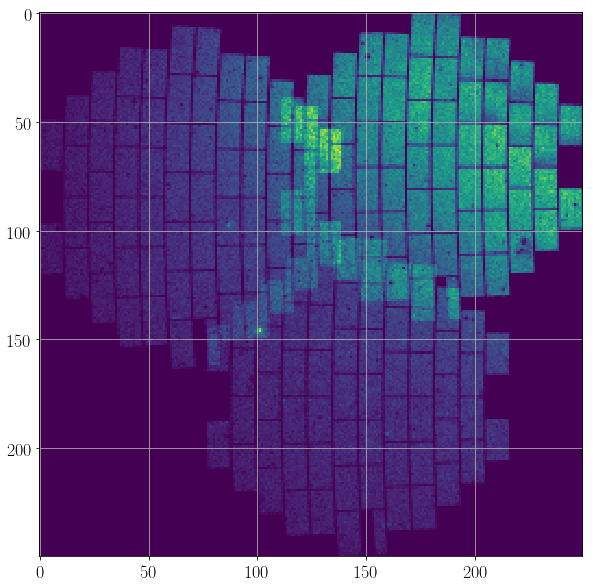

In [33]:
plt.figure(figsize=(10,10))
#plt.subplot(projection=wcs)
plt.imshow(image_hist, interpolation=None)
plt.grid()
plt.show()

/user/HS128/pm00518/virtualenvs/venv/lib/python3.5/site-packages/matplotlib/colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


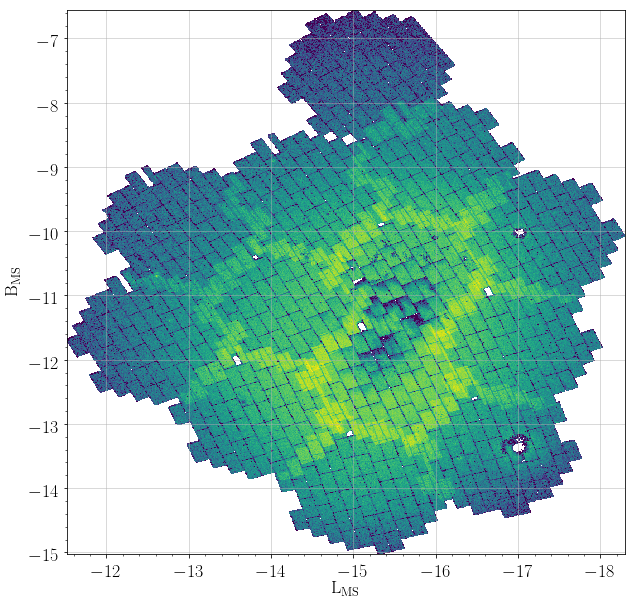

In [67]:
plt.figure(figsize=(10,10))
plt.hist2d(ms_l, ms_b, bins = (1000, 1000), cmin=1, norm = matplotlib.colors.LogNorm())
plt.xlabel('L$_{\mathrm{MS}}$')
plt.ylabel('B$_{\mathrm{MS}}$')
plt.gca().invert_xaxis()
plt.grid(alpha=0.6)
plt.minorticks_on()
plt.show()

In [46]:
temp_header['CTYPE1'] = 'RA---SIN'
temp_header['CTYPE2'] = 'DEC--SIN'
temp_header['NAXIS'] = 2
temp_header['NAXIS1'] = len(xbins)-1
temp_header['NAXIS2'] = len(ybins)-1
temp_header['CRVAL1'] = (max(xbins)+min(xbins))/2.0
temp_header['CRVAL2'] = (max(ybins)+min(ybins))/2.0
temp_header['CRPIX1'] = (len(xbins)-1)/2.0
temp_header['CRPIX2'] = (len(ybins)-1)/2.0
temp_header['CUNIT1'] = 'deg'
temp_header['CUNIT2'] = 'deg'
temp_header['CDELT1'] = 0.01
temp_header['CDELT2'] = 0.005
wcs = WCS(temp_header)
print(wcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 19.51642137250689  -74.66851809765164  
CRPIX : 500.0  500.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.01  0.005  
NAXIS : 1000  1000


# Back to cross-match

Ok, so now we have the file with all the fields, finally. The next step is to do the cross-match with nway, but first we need to prepare the fits files with a header keyword for the area.

In [16]:
# Function that calculates the area in a sky region occupied by a given number of stars. The function bins the sky and counts the number of bins with data in it. The size of the bins can be changed accordingly by changing their number. The input must be a numpy array with the first 2 columns being RA and DEC in degrees.
def field_area_calculator (data, bin_number):
    # First of all, we must double check that the field is not in the meridian of RA=0, because this would cause problems with how the code computes the area. If it is in that meridian, we set the values in the 3rd and 4th quadrant to the 0 to -180 interval. In this way we have the values in this meridian continuous. Of course we expect to have no values in the 180 meridian cause this would cause the same problem again.
    if (max(data[0])-min(data[0])) > 180:
        new_ra = np.where(data[0] > 180, data[0] - 360, data[0])
    else:
        new_ra = data[0]
    
    
    # Then, we make an histogram of the data with the amount of bins provided.
    hist_coord = np.histogram2d(new_ra, data[1], bins = bin_number)
    
    # Then, we put nans on the zeros so that they appear white in the figure.
    hist_coord[0] [hist_coord[0] == 0.] = np.nan
    # We save a figure just to check if the histogram has enough/too much resolution.
    #plt.figure(1, figsize=(16,9))
    #plt.imshow(hist_coord[0])
    #plt.savefig('/home/pol/Documents/PhD/CMD_SMASH/Plots/Field%sSkyView.png' % (field))
#    plt.show()
    #plt.close()


    # We first compute the area of each bin, correcting the dra variable for cos(delta), which takes into account the fact that a RA circle at DEC=0 is greater that one at DEC=80.
    dra = np.diff(hist_coord[1])
    ddec = np.diff(hist_coord[2])
    mid_dec = (hist_coord[2][1:] + hist_coord[2][:-1]) * 0.5
    dra_cosdelta = dra * np.cos(np.deg2rad(mid_dec))
    # This line below creates a 2D grid of areas, to ensure that later on every bin is multiplied for the correct amount.
    area_bin = dra_cosdelta[:, None] * ddec
    hist_coord[0] [hist_coord[0] > 0.] = 1.0
    # We sum all the bins and mulpiply for the area of each bin.
    area = np.nansum(hist_coord[0] * area_bin)
    #print 'Field %s Area (degrees^2): ' % (field), area
    return area

/user/HS128/pm00518/virtualenvs/venv/lib/python3.5/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater


50 8.735701079174994
60 8.64257950798112
70 8.546976205919073
80 8.510490190029856
90 8.43413043063048
100 8.449378428848842
110 8.407903386920836
120 8.370176427389438
130 8.332930215252764
140 8.344604500468618
150 8.306009057788154
160 8.305165911483064
170 8.276747285163735
180 8.282603428588544
190 8.276572235480515
200 8.2502763819713
210 8.23709875836566
220 8.228868762843542
230 8.199481475191261
240 8.169730003544124
250 8.142638351732923
260 8.112354709457684
270 8.072103136739686
280 8.041760523963456
290 8.0178398557574


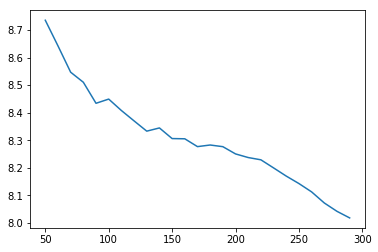

In [18]:
bin_numbers = np.arange(50, 300, 10)
areas = []
for bin_number in bin_numbers:
    areas.append(field_area_calculator([hdu.data['RA'], hdu.data['DEC']], bin_number))
    print(bin_number, areas[-1])
plt.plot(bin_numbers, areas)
plt.show()

In [35]:
%cd ../virtualenvs/venv/bin/

/user/HS128/pm00518/virtualenvs/venv/bin


In [36]:
!python nway-write-header.py /scratch/SMASH_DATA/combined_fields.fits COMB 8.28

current  SKYAREA: None
new     COMB SKYAREA: 8.28


That's it done for the 'big' file. Now we will fill all the rest of the files. Since I already calculated the areas for each of them I will just include them all at once and I don't have to do it again.

In [10]:
areas_fields = np.loadtxt('/scratch/SMASH_DATA/Field_area_info.txt')
for field, area in zip(areas_fields.T[0], areas_fields.T[1]):
    field_str = str(int(field))
    field_name = '/scratch/SMASH_DATA/Field%s_allobj_stars.fits.gz' % (field_str)
    #os.system('python /user/HS128/pm00518/virtualenvs/venv/bin/nway-write-header.py field_name field_str area')
    hdu = fits.open(field_name)
    hdu[1].name = field_str
    hdu[1].header['SKYAREA'] = area
    hdu.writeto(field_name, overwrite=True)
    print('New area introduced correctly for field: ' + field_str)

New area introduced correctly for field: 1
New area introduced correctly for field: 2
New area introduced correctly for field: 3
New area introduced correctly for field: 4
New area introduced correctly for field: 5
New area introduced correctly for field: 6
New area introduced correctly for field: 7
New area introduced correctly for field: 8
New area introduced correctly for field: 9
New area introduced correctly for field: 10
New area introduced correctly for field: 11
New area introduced correctly for field: 12
New area introduced correctly for field: 13
New area introduced correctly for field: 14
New area introduced correctly for field: 15
New area introduced correctly for field: 16
New area introduced correctly for field: 17
New area introduced correctly for field: 18
New area introduced correctly for field: 19
New area introduced correctly for field: 20
New area introduced correctly for field: 21
New area introduced correctly for field: 22
New area introduced correctly for field: 

In [14]:
!python nway.py /scratch/SMASH_DATA/combined_fields.fits :RA_ERR /scratch/SMASH_DATA/Field11_allobj_stars.fits.gz :RA_ERR /scratch/SMASH_DATA/Field12_allobj_stars.fits.gz :RA_ERR /scratch/SMASH_DATA/Field16_allobj_stars.fits.gz :RA_ERR --radius 2.0 --out=/scratch/SMASH_DATA/cross_match_test1.fits

NWAY arguments:
    catalogues:  /scratch/SMASH_DATA/combined_fields.fits, /scratch/SMASH_DATA/Field11_allobj_stars.fits.gz, /scratch/SMASH_DATA/Field12_allobj_stars.fits.gz, /scratch/SMASH_DATA/Field16_allobj_stars.fits.gz
    position errors/columns:  :RA_ERR, :RA_ERR, :RA_ERR, :RA_ERR
      from catalogue "COMB" (2161839), density gives 1.08e+10 on entire sky
      from catalogue "11" (1253592), density gives 1.87e+10 on entire sky
      from catalogue "12" (515997), density gives 7.55e+09 on entire sky
      from catalogue "16" (392250), density gives 5.76e+09 on entire sky
    magnitude columns:  

matching with 2.000000 arcsec radius
matching: 2554883672304844240 naive possibilities
matching: hashing
    using RA  columns: RA, RA, RA, RA
    using DEC columns: DEC, DEC, DEC, DEC
matching: healpix hashing on pixel resolution ~ 2.254538 arcsec (nside=65536)
100%|4323678|###################################################|Time:  0:00:50
matching: collecting from 7158322 buckets, cre

In [13]:
%cd /user/HS128/pm00518/virtualenvs/venv/bin/

/user/HS128/pm00518/virtualenvs/venv/bin
